# PTEN cis effect

This notebook creates a boxplot for the cis effect of PTEN cnv deletions in 8 cancers. These 8 cancers were chosen because they have enough samples with PTEN cnv deletions to do a t-test. Only Ccrcc does not have enough samples with deletions. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('cptac version:', cptac.version())

cptac version: 0.8.6


Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation type from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [4]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [5]:
def find_multi_cis_mut(cancer_obj,cis_gene):
    #Get all somatic mutations 
    mutations = cancer_obj.get_somatic_mutation()
    #get just somatic mutations for cis_gene
    cis_mut = mutations[mutations.Gene == cis_gene]
    cis_mut = cis_mut[["Mutation"]]
    # Multiple somatic mutations are indicated using multiple rows with the same patient ids.
    # We will group the rows by patient ids and then relabel the columns that have multiple mutations 
    
    cis_mut = cis_mut.groupby(level=['Patient_ID'], sort=False).agg( ','.join)
    cis_mut = cis_mut.replace(regex=[',' + cis_gene], value='')
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: 'Multiple_Missense' if 'Missense_Mutation,Missense_Mutation' in x else x)
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: 'Multiple_Frame_Shift_Del' if 'Frame_Shift_Del,Frame_Shift_Del' in x else x)
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: 'Multiple_Splice_Site' if 'Splice_Site,Splice_Site' in x else x)
   
   #get CNV mutations 
    mut_copy_num = cancer_obj.get_genotype_all_vars(cis_gene, mutations_filter = ["Deletion","Amplification"])
    mut_copy_num = mut_copy_num.rename(columns={'Mutation': 'CNV_Mutation'})
    mut_copy_num = mut_copy_num["CNV_Mutation"]
    mutations = pd.merge(mut_copy_num, cis_mut, on="Patient_ID", how = "outer")
   
     
    # If mutation column is NaN replace with value in Mutation_Copy_Num
    mutations['Mutation'] = mutations.apply(
        lambda row: row['CNV_Mutation'] if pd.isnull(row['Mutation']) else row['Mutation'], axis=1)
   
    #Make column All_Mutation which is a list of all mutations 
    
    mutations['All_Mutations_'+cis_gene] = mutations.apply(
        lambda row: [row["CNV_Mutation"] , row["Mutation"]] if (row["CNV_Mutation"] != row["Mutation"]) else [row['Mutation']], axis=1)
    mutations = mutations.rename(columns={'All_Mutations': 'All_Mutations_' + cis_gene})
    return mutations


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac.

In [6]:
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

# Get PTEN deletion

In [7]:
#Select the cancers that you would like to test and add cptac data into a dictionary
cptac_cancers = {'GBM':g, 'HNSCC':h, 'LUAD':l, 'LSCC':ls, 'BR':b, 'CO':col, 'OV':o}
cis_gene1 = "PTEN"
gene1_mut = ["Deletion", "Wildtype_Tumor"]
cis_gene2 = "PIK3CA"
gene2_mut = ["Wildtype_Tumor"]

merged_dfs = {}
for cancer in cptac_cancers:

    gene1_mutations = find_multi_cis_mut(cptac_cancers[cancer],cis_gene1)
    gene1_mutations = gene1_mutations["All_Mutations_"+cis_gene1]

    gene2_mutations = find_multi_cis_mut(cptac_cancers[cancer],cis_gene2)
    gene2_mutations = gene2_mutations["All_Mutations_"+cis_gene2] 

    gene1_gene2 = pd.merge(gene1_mutations, gene2_mutations, on="Patient_ID", how = "outer")
    gene1_gene2['All_Mutations_' + cis_gene1] = [','.join(map(str, l)) for l in gene1_gene2['All_Mutations_' + cis_gene1]]

    gene1_gene2['All_Mutations_'+ cis_gene2] = [','.join(map(str, l)) for l in gene1_gene2['All_Mutations_'+cis_gene2]]
    gene1_gene2["Cancer"] = cancer
    
    #only gene1 with specified mutation
    gene1_mutated = gene1_gene2.loc[gene1_gene2['All_Mutations_'+cis_gene1].isin(gene1_mut)]
    
    #gene1 mutated with only gene2 wildtype
    gene1_mut_gene2_wt = gene1_mutated.loc[gene1_mutated['All_Mutations_' + cis_gene2].isin(gene2_mut)]

    merged_dfs[cancer] = gene1_mut_gene2_wt
    # Create csv
    #gene1_mut_gene2_wt.to_csv('csv/'+cancer+'_pten_mut_pik3ca_wt.csv', index=False)
    print(cancer, gene1_mut_gene2_wt[["All_Mutations_"+cis_gene1]].value_counts(), '\n')
    

GBM All_Mutations_PTEN
Deletion              42
Wildtype_Tumor        13
dtype: int64 

HNSCC All_Mutations_PTEN
Wildtype_Tumor        47
Deletion               1
dtype: int64 

LUAD All_Mutations_PTEN
Deletion              12
dtype: int64 

LSCC All_Mutations_PTEN
Wildtype_Tumor        12
Deletion               3
dtype: int64 

BR All_Mutations_PTEN
Wildtype_Tumor        36
Deletion              10
dtype: int64 

CO All_Mutations_PTEN
Wildtype_Tumor        48
Deletion              14
dtype: int64 

OV All_Mutations_PTEN
Wildtype_Tumor        15
Deletion               5
dtype: int64 



In [19]:
gene = 'PTEN'
plot_dfs = {}

for cancer in cptac_cancers:
    ca = cptac_cancers[cancer]
    
    # get proteomics
    prot = ca.get_proteomics(tissue_type = 'tumor') 
    if isinstance(prot.keys(), pd.core.indexes.multi.MultiIndex):
        prot = u.reduce_multiindex(prot, levels_to_drop = 1)
    prot = prot[['PTEN']]

    # get proteomics and only pten deletion
    mut_df = merged_dfs[cancer]
    pten_mut = mut_df[['All_Mutations_'+gene]]
    only_del = prot.join(pten_mut, how = 'outer')
    pten_del = only_del.dropna(subset = ['All_Mutations_'+gene]) # keep only pten deletions (no pik3ca mut)
    pten_del['cancer'] = cancer

    plot_dfs[cancer] = pten_del
    
    print(cancer, pten_del[["All_Mutations_"+gene]].value_counts(), '\n')
    
    pval = u.wrap_ttest(pten_del, 'All_Mutations_'+gene, ['PTEN'], mincount = 3, return_all = True)
    print(pval, '\n')
    

GBM All_Mutations_PTEN
Deletion              42
Wildtype_Tumor        13
dtype: int64 

  Comparison  P_Value
0       PTEN  0.00005 

HNSCC All_Mutations_PTEN
Wildtype_Tumor        47
Deletion               1
dtype: int64 

Incorrectly Formatted Dataframe!
None 

LUAD All_Mutations_PTEN
Deletion              12
dtype: int64 

Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.
None 

LSCC All_Mutations_PTEN
Wildtype_Tumor        12
Deletion               3
dtype: int64 

Incorrectly Formatted Dataframe!
None 

BR All_Mutations_PTEN
Wildtype_Tumor        36
Deletion              10
dtype: int64 

  Comparison   P_Value
0       PTEN  0.007543 

CO All_Mutations_PTEN
Wildtype_Tumor        48
Deletion              14
dtype: int64 

  Comparison   P_Value
0       PTEN  0.038521 

OV All_Mutations_PTEN
Wildtype_Tumor        15
Deletion               5
dtype: int64 

  Comparison   P_Value
0       PTEN  0.152313 



# Endometrial

The Endometrial data set does not have enough cnv deletions to perform a t-test, however the data set does have enough truncation type mutations (nonsense and frame shifts). Different code is needed to create the data frame for Endometrial.

In [9]:
#Select the cancers that you would like to test and add cptac data into a dictionary
endo = {'EC':en}
cis_gene1 = "PTEN"
gene1_mut = ["Nonsense_Mutation", 'Frame_Shift_Ins', 'Frame_Shift_Del', "Wildtype_Tumor"]
cis_gene2 = "PIK3CA"
gene2_mut = ["Wildtype_Tumor"]

endo_df = {}
for cancer in endo:

    gene1_mutations = find_multi_cis_mut(endo[cancer],cis_gene1)
    gene1_mutations = gene1_mutations["All_Mutations_"+cis_gene1]

    gene2_mutations = find_multi_cis_mut(endo[cancer],cis_gene2)
    gene2_mutations = gene2_mutations["All_Mutations_"+cis_gene2] 

    gene1_gene2 = pd.merge(gene1_mutations, gene2_mutations, on="Patient_ID", how = "outer")
    gene1_gene2['All_Mutations_' + cis_gene1] = [','.join(map(str, l)) for l in gene1_gene2['All_Mutations_' + cis_gene1]]

    gene1_gene2['All_Mutations_'+ cis_gene2] = [','.join(map(str, l)) for l in gene1_gene2['All_Mutations_'+cis_gene2]]
    gene1_gene2["Cancer"] = cancer
    
    #only gene1 with specified mutation
    gene1_mutated = gene1_gene2.loc[gene1_gene2['All_Mutations_'+cis_gene1].isin(gene1_mut)]
    
    #gene1 mutated with only gene2 wildtype
    gene1_mut_gene2_wt = gene1_mutated.loc[gene1_mutated['All_Mutations_' + cis_gene2].isin(gene2_mut)]

    endo_df[cancer] = gene1_mut_gene2_wt
    # Create csv
    #gene1_mut_gene2_wt.to_csv('csv/'+cancer+'_pten_mut_pik3ca_wt.csv', index=False)
    print(cancer, gene1_mut_gene2_wt[["All_Mutations_"+cis_gene1]].value_counts(), '\n')
    

EC All_Mutations_PTEN
Wildtype_Tumor        6
Frame_Shift_Del       5
Frame_Shift_Ins       2
Nonsense_Mutation     1
dtype: int64 



In [10]:
gene = 'PTEN'

for cancer in endo:
    ca = endo[cancer]
    
    # get proteomics
    prot = ca.get_proteomics(tissue_type = 'tumor') 
    prot = prot[['PTEN']]
    
    # get proteomics and only pten deletion
    mut_df = endo_df[cancer]
    pten_mut = mut_df[['All_Mutations_'+gene]]
    only_del = prot.join(pten_mut, how = 'outer')
    pten_del = only_del.dropna(subset = ['All_Mutations_'+gene]) # keep only pten deletions (no pik3ca mut)
    pten_del['cancer'] = cancer
    
    pten_del['All_Mutations_'+gene] = np.where(
                        pten_del['All_Mutations_'+gene] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

    plot_dfs[cancer] = pten_del
    
    print(cancer, pten_del[["All_Mutations_"+gene]].value_counts(), '\n')
    
    pval = u.wrap_ttest(pten_del, 'All_Mutations_'+gene, ['PTEN'], mincount = 3, return_all = True)
    print(pval, '\n')
    

EC All_Mutations_PTEN
Truncation            8
Wildtype_Tumor        6
dtype: int64 

  Comparison   P_Value
0       PTEN  0.077656 



# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

Next append the dfs.

In [11]:
all_df = pd.DataFrame()
for cancer in plot_dfs:
    df = plot_dfs[cancer]
    print(cancer, len(df))
    all_df = all_df.append(df) 

GBM 55
HNSCC 48
LUAD 12
LSCC 15
BR 46
CO 62
OV 20
EC 14


In [12]:
all_df = all_df.loc[all_df['cancer'] != 'HNSCC'] #take out hnscc (different scale)

# Step 3: Create the Pancancer Boxplot

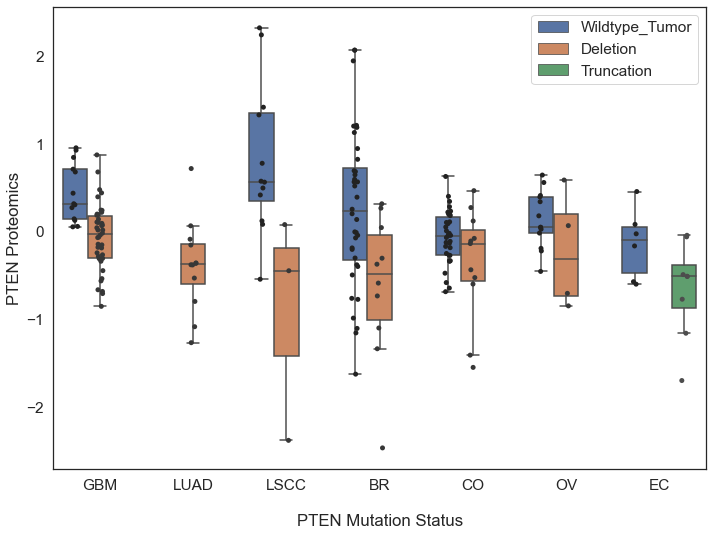

In [15]:
# cis plot
gene = 'PTEN'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4, style = 'white')

boxplot = sns.boxplot(data = all_df, x='cancer', y=gene, hue = 'All_Mutations_'+gene,
                      hue_order = ["Wildtype_Tumor", "Deletion", 'Truncation'], showfliers = False)    
#boxplot.set_title('Pancancer cis effect of PTEN CNV Deletions')
boxplot = sns.stripplot(data = all_df, x='cancer', y=gene, jitter = True, 
                           color = ".3", hue = 'All_Mutations_'+gene, hue_order = ["Wildtype_Tumor", "Deletion", 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Mutation Status", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

In [ ]:
# Save figure
fig = boxplot.get_figure()
#fig.savefig("Sup_Fig_4A.png", dpi = 300)

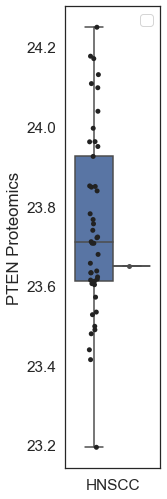

In [16]:
# Figure for Hnscc (higher scale)
gene = 'PTEN'
df = plot_dfs['HNSCC']
plt.rcParams['figure.figsize']=(1.7,8.5) #size of plot
sns.set(font_scale = 1.4, style = 'white')

boxplot = sns.boxplot(x='cancer', y=gene, data = df, hue = 'All_Mutations_'+gene,
                      hue_order = ["Wildtype_Tumor", "Deletion"], showfliers = False)    
boxplot = sns.stripplot(x='cancer', y=gene, data = df, jitter = True, 
                           color = ".3", dodge = True, hue = 'All_Mutations_'+gene, hue_order = ["Wildtype_Tumor", "Deletion"],)
boxplot.set(xlabel = "", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:0], labels[0:0])

#format_pval_annotation(symbols['HNSCC'], -.2, .2, 24.8) '''

plt.show()
plt.clf()
plt.close()

In [ ]:
# Save figure
fig = boxplot.get_figure()
#fig.savefig("Sup_Fig_4B.png", bbox_inches="tight", dpi = 300)